# Financial News Sentiment Analysis
##By Tan Xin Yi (1211100903) & Tang Yu Xuan (1211103236)

### This is a notebook containing Sentiment Analysis on Financial News Statements. Natural Language Processing has powerful applications in financial analysis, as it allows us to gain insights from textual data. This project aims to build a model that can accurately classify financial news statements into positive, negative, or neutral sentiments.

## Libraries

In [ ]:
!pip install pandas numpy matplotlib seaborn nltk textblob wordcloud scikit-learn imbalanced-learn transformers datasets torch

In [ ]:
# Data Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Text Libraries
import string
import re
import nltk
import nltk.corpus
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt_tab')
from nltk.stem import WordNetLemmatizer

# EDA Analysis# Text Polarity
from textblob import TextBlob

# Text Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Word Cloud
from wordcloud import WordCloud

# Feature Engineering
# Label Encoding
from sklearn.preprocessing import LabelEncoder

# TF-IDF Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Opinion Mining
import spacy
from spacy import displacy

# Aspect-Based Sentiment Analysis (ABSA)
from textblob import TextBlob

# Resampling
from imblearn.over_sampling import SMOTE
from collections import Counter

# Splitting Dataset
from sklearn.model_selection import train_test_split

# Model Selection and Evaluation
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Model Metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import os
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


# The Dataset

### The dataset contains financial news statements with sentiment labels. Each statement is categorized as positive, negative, or neutral, reflecting the sentiment expressed in the financial context.

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

drive_path = '/content/drive/MyDrive/social media computing/' #set your google drive path

# Check if folder exists
if os.path.exists(drive_path):
    print("Folder found. Listing files:")
    print(os.listdir(drive_path))
else:
    print("Folder not found. Please check the path.")

Mounted at /content/drive
Folder found. Listing files:
['data.csv', 'xySCM.ipynb', 'SCM.ipynb', 'Doodle of SCM.ipynb']


In [ ]:
dataset = pd.read_csv(drive_path + 'data.csv')
dataset.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [ ]:
dataset.shape

(5842, 2)

# Data Preprocessing

### Checking Null Values

In [ ]:
dataset.isnull().sum()

,0
Sentence,0
Sentiment,0


In [ ]:
dataset.columns

Index(['Sentence', 'Sentiment'], dtype='object')

## Text Cleaning & Preprocessing

We apply a two-step process to clean and prepare financial text for analysis:

#### 1. **Text Cleaning**
- Lowercases all text for normalization.
- Preserves financial entities:
  - Converts stock tickers (e.g., `$AAPL`) → `TICKER_AAPL`
  - Formats dollar values (e.g., `$100.5`) → `100.5_dollars`
  - Formats percentages (e.g., `12.5%`) → `12.5_percent`
- Removes URLs, newline characters, and non-informative punctuation (except underscores).
- Normalizes whitespace.

#### 2. **Text Processing**
- Uses a **custom stopword list**, preserving key financial and sentiment-related terms  
  (e.g., `"increase"`, `"low"`, `"not"`).
- Performs **tokenization** using NLTK.
- **Lemmatizes** non-financial tokens to their base form.
- Keeps placeholders like `_dollars`, `_percent`, and `TICKER_` intact for downstream model use.

> This approach improves semantic retention in sentiment and financial NLP tasks by preserving domain-specific context.


In [ ]:
def Text_Cleaning(text):
    # Lowercase the text
    text = text.lower()

    # Preserve financial symbols and tickers by temporarily replacing them
    # Match stock tickers (usually all caps with 1-5 letters)
    text = re.sub(r'\$([A-Z]{1,5})\b', ' TICKER_\\1 ', text)

    # Handle percentages - convert to standard format
    text = re.sub(r'(\d+(\.\d+)?)%', '\\1_percent', text)

    # Preserve dollar amounts
    text = re.sub(r'\$(\d+(\.\d+)?)', '\\1_dollars', text)

    # Clean punctuation (but keep underscores for our placeholders)
    punct_to_remove = string.punctuation.replace('_', '')
    translator = str.maketrans(punct_to_remove, ' '*len(punct_to_remove))
    text = text.translate(translator)

    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove newlines
    text = re.sub(r'\n', ' ', text)

    # Normalize whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

def Text_Processing(text):
    # Customize stopwords for financial text - keep important negation and financial terms
    financial_stopwords = set(nltk.corpus.stopwords.words("english")) - set([
        "not", "no", "nor", "up", "down", "above", "below", "high", "low",
        "more", "most", "less", "least", "against", "very", "increase", "decrease"
    ])

    processed_text = []
    lemmatizer = WordNetLemmatizer()

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize and remove stopwords
    for word in tokens:
        # Keep financial indicators intact (our placeholders)
        if '_dollars' in word or '_percent' in word or 'TICKER_' in word:
            processed_text.append(word)
        elif word not in financial_stopwords: # if the word is not stopwords, we lemmatize them
            # lemmatization -> reduces words to their base or dictionary form (lemma) by considering context and meaning
            lemma = lemmatizer.lemmatize(word)
            processed_text.append(lemma)

    return " ".join(processed_text)

In [ ]:
dataset["processed_text"] = dataset["Sentence"].apply(lambda Text: Text_Cleaning(Text))
dataset["processed_text"] = dataset["processed_text"].apply(lambda Text: Text_Processing(Text))

In [ ]:
dataset

,Sentence,Sentiment,processed_text
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi low down 1 50_dollars 2 50_dollars bk real...
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale doubled ...
3,According to the Finnish-Russian Chamber of Co...,neutral,according finnish russian chamber commerce maj...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sold remaining 22 4 percen...
...,...,...,...
5837,RISING costs have forced packaging producer Hu...,negative,rising cost forced packaging producer huhtamak...
5838,Nordic Walking was first used as a summer trai...,neutral,nordic walking first used summer training meth...
5839,"According shipping company Viking Line , the E...",neutral,according shipping company viking line eu deci...
5840,"In the building and home improvement trade , s...",neutral,building home improvement trade sale decreased...


# Exploratory Data Analysis

In [ ]:
dataset.head(n=10)

,Sentence,Sentiment,processed_text
0,The GeoSolutions technology will leverage Bene...,positive,geosolutions technology leverage benefon gps s...
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative,esi low down 1 50_dollars 2 50_dollars bk real...
2,"For the last quarter of 2010 , Componenta 's n...",positive,last quarter 2010 componenta net sale doubled ...
3,According to the Finnish-Russian Chamber of Co...,neutral,according finnish russian chamber commerce maj...
4,The Swedish buyout firm has sold its remaining...,neutral,swedish buyout firm sold remaining 22 4 percen...
5,$SPY wouldn't be surprised to see a green close,positive,spy surprised see green close
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative,shell 70_dollars billion bg deal meet sharehol...
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative,ssh communication security corp stock exchange...
8,Kone 's net sales rose by some 14 % year-on-ye...,positive,kone net sale rose 14 year year first nine mon...
9,The Stockmann department store will have a tot...,neutral,stockmann department store total floor space 8...


# Polarity, Sentence Length, and Word Counts
Analyze the polarity of the texts and examine the characteristics of the sentences by word count and length. This histogram shows the distribution of polarity scores across our dataset. Negative polarity (-1 to 0) suggests negative sentiment, while positive polarity (0 to 1) indicates positive sentiment.

### Polarity Histogram


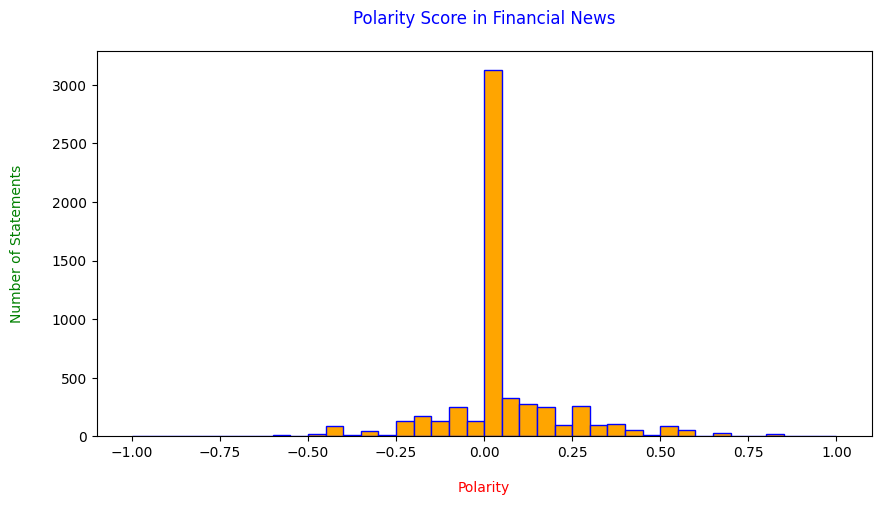

In [ ]:
# TextBlob is a Python library that makes it super easy to process and analyze text data -> it understands the Sentiment in a form of polarity and subjectivity
dataset["polarity"] = dataset["processed_text"].map(lambda Text: TextBlob(Text).sentiment.polarity)

dataset["polarity"].plot(kind="hist", bins=40, edgecolor="blue", linewidth=1, color="orange", figsize=(10,5))
plt.title("Polarity Score in Financial News", color="blue", pad=20)
plt.xlabel("Polarity", labelpad=15, color="red")
plt.ylabel("Number of Statements", labelpad=20, color="green")
plt.show()

### Sentence Length Histogram




This histogram shows the distribution of sentence lengths in our dataset, allowing us to identify if there are any patterns in statement length by sentiment.

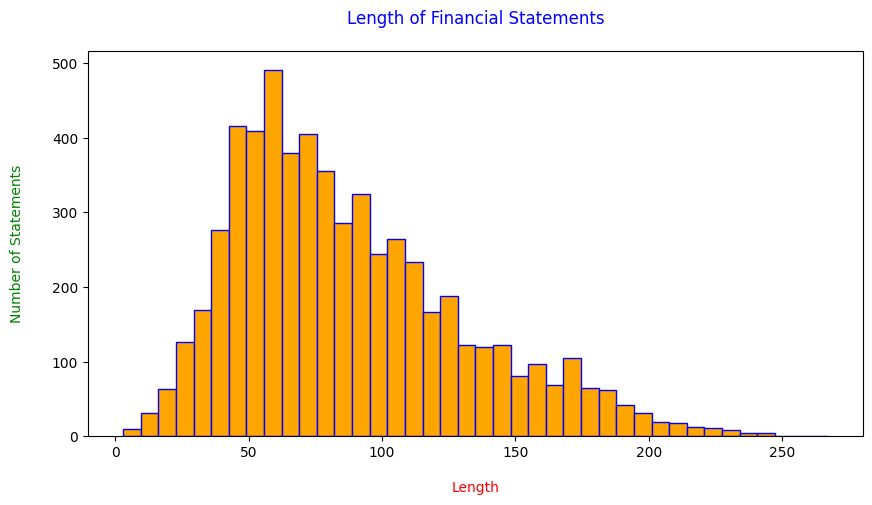

In [ ]:
dataset["length"] = dataset["processed_text"].astype(str).apply(len)

dataset["length"].plot(kind="hist", bins=40, edgecolor="blue", linewidth=1, color="orange", figsize=(10,5))
plt.title("Length of Financial Statements", color="blue", pad=20)
plt.xlabel("Length", labelpad=15, color="red")
plt.ylabel("Number of Statements", labelpad=20, color="green")
plt.show()

### Word Count Histogram
This histogram shows the distribution of word counts in our dataset, helping us understand the typical length of financial statements by word count.

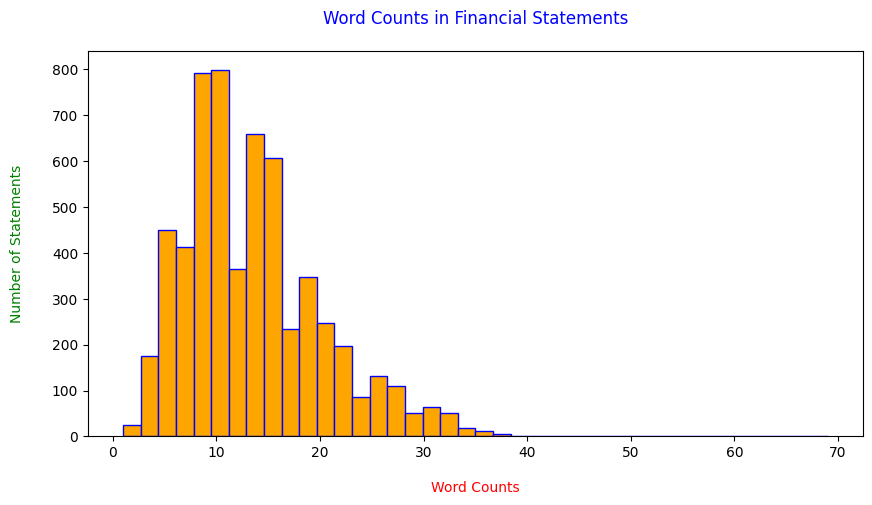

In [ ]:
dataset["word_counts"] = dataset["processed_text"].apply(lambda x: len(str(x).split()))

dataset["word_counts"].plot(kind="hist", bins=40, edgecolor="blue", linewidth=1, color="orange", figsize=(10,5))
plt.title("Word Counts in Financial Statements", color="blue", pad=20)
plt.xlabel("Word Counts", labelpad=15, color="red")
plt.ylabel("Number of Statements", labelpad=20, color="green")
plt.show()

# N-gram analysis
This function extracts the top **N most frequent N-grams** (phrases with `Gram` number of words) from a given text corpus.

#### How it works:
1. **Vectorization**: Converts text into a matrix of N-gram counts using `CountVectorizer`, while removing common stop words.
2. **Count Frequencies**: Sums up how often each N-gram appears across all documents.
3. **Pairing & Sorting**: Pairs each N-gram with its count, sorts them in descending order.
4. **Return Top N**: Outputs the top `N` most frequent N-grams.

#### Use Case:
Useful for identifying commonly used phrases in text datasets, aiding in tasks like keyword extraction, topic modeling, or content analysis.

In [ ]:
def Gram_Analysis(Corpus, Gram, N):
  # Define financial stopwords - keep important negation and financial terms
  financial_stopwords = list(set(nltk.corpus.stopwords.words("english")) - set([
      "not", "no", "nor", "up", "down", "above", "below", "high", "low",
      "more", "most", "less", "least", "against", "very", "increase", "decrease"
  ]))

  # Vectorizer - Convert the set to a list
  Vectorizer = CountVectorizer(stop_words=financial_stopwords, ngram_range=(Gram,Gram))

  # N-Grams Matrix
  ngrams = Vectorizer.fit_transform(Corpus)

  # N-Grams Frequency
  Count = ngrams.sum(axis=0)

  # List of Words
  words = [(word, Count[0, idx]) for word, idx in Vectorizer.vocabulary_.items()]

  # Sort Descending With Key = Count
  words = sorted(words, key=lambda x:x[1], reverse=True)

  return words[:N]

## Filter The DataFrame Based On Sentiments

In [ ]:
# Use dropna() so the base DataFrame is not affected
Positive = dataset[dataset["Sentiment"] == "positive"].dropna()
Neutral = dataset[dataset["Sentiment"] == "neutral"].dropna()
Negative = dataset[dataset["Sentiment"] == "negative"].dropna()

## Unigram of Statements Based on Sentiments

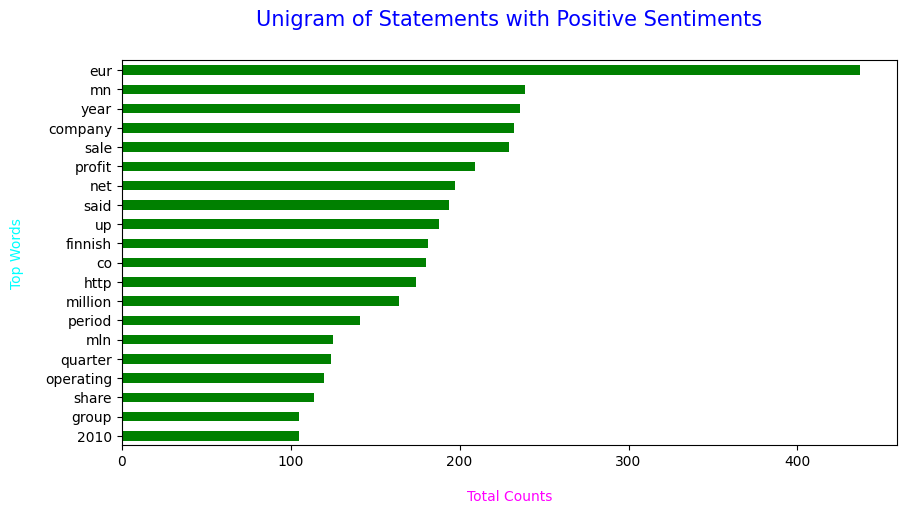

In [ ]:
# Finding Unigram for Positive Sentiments
words = Gram_Analysis(Positive["processed_text"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green")
plt.title("Unigram of Statements with Positive Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

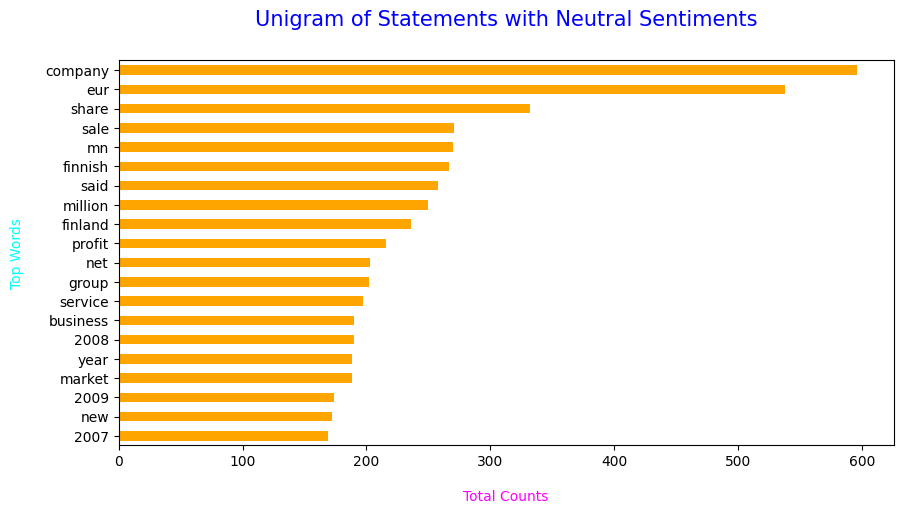

In [ ]:
# Finding Unigram for Neutral Sentiments
words = Gram_Analysis(Neutral["processed_text"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="orange")
plt.title("Unigram of Statements with Neutral Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

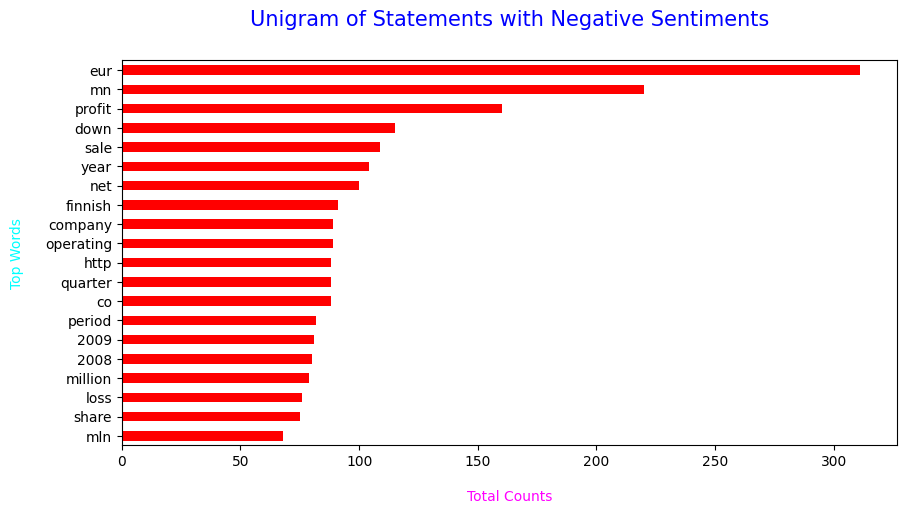

In [ ]:
# Finding Unigram for Negative Sentiments
words = Gram_Analysis(Negative["processed_text"], 1, 20)
Unigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Unigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="red")
plt.title("Unigram of Statements with Negative Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

## Bigram of Statements Based On Sentiments

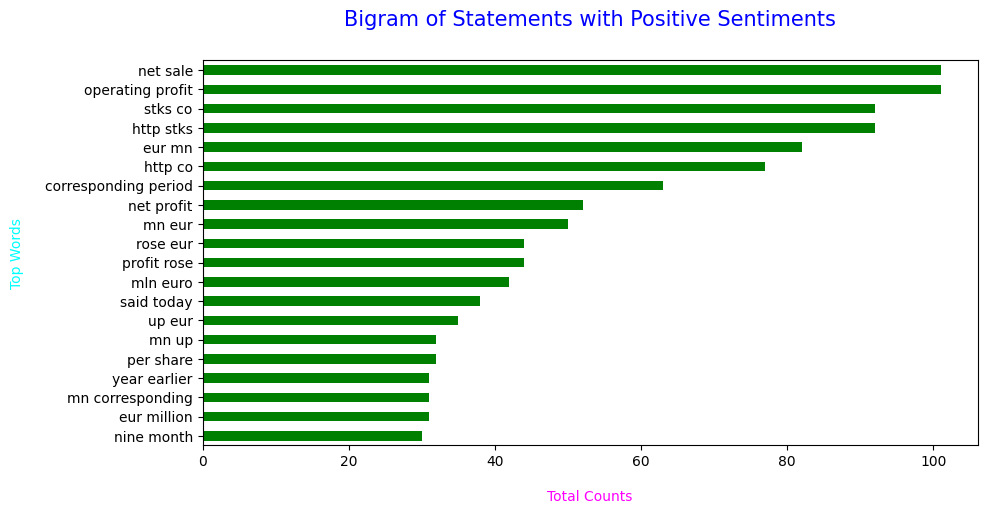

In [ ]:
# Finding Bigram for Positive Sentiments
words = Gram_Analysis(Positive["processed_text"], 2, 20)
Bigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green")
plt.title("Bigram of Statements with Positive Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

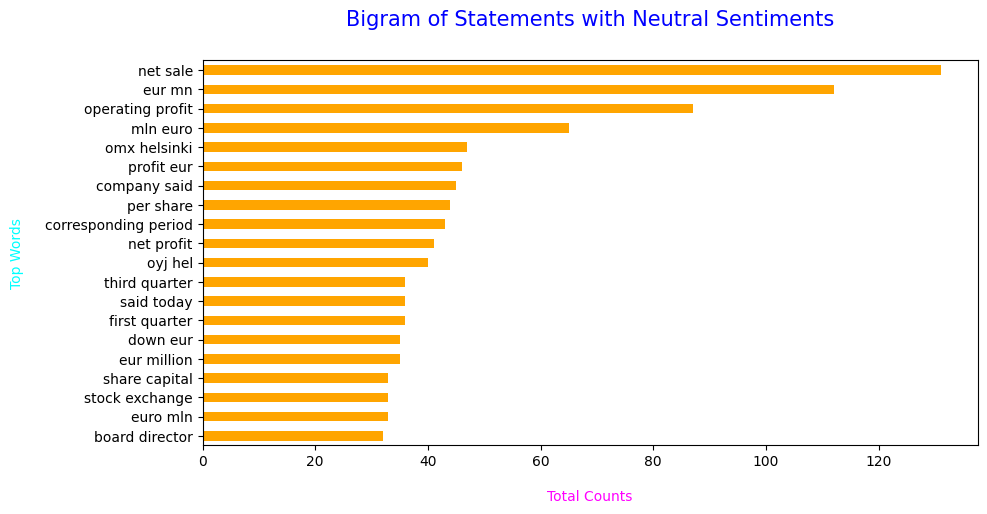

In [ ]:
# Finding Bigram for Neutral Sentiments
words = Gram_Analysis(Neutral["processed_text"], 2, 20)
Bigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="orange")
plt.title("Bigram of Statements with Neutral Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

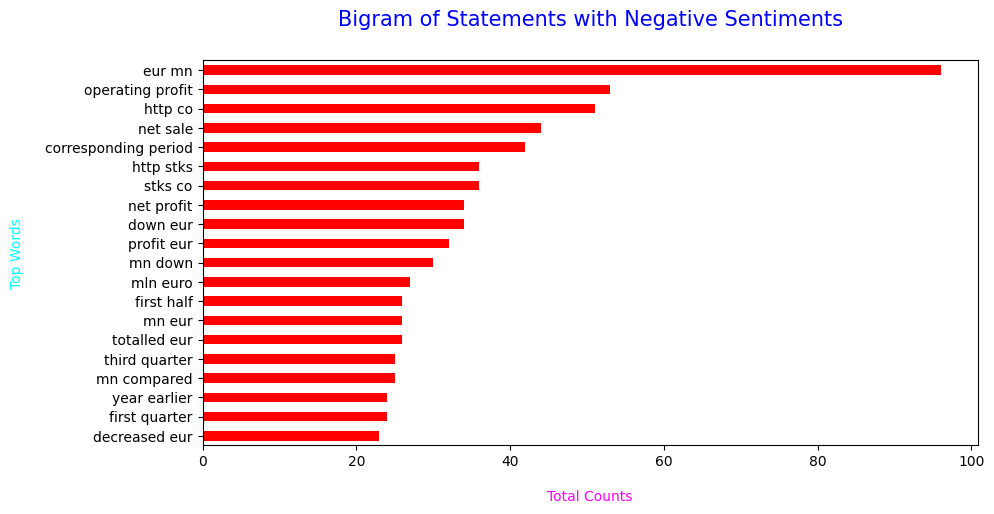

In [ ]:
# Finding Bigram for Negative Sentiments
words = Gram_Analysis(Negative["processed_text"], 2, 20)
Bigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Bigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="red")
plt.title("Bigram of Statements with Negative Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

## Trigram of Statements Based On Sentiments

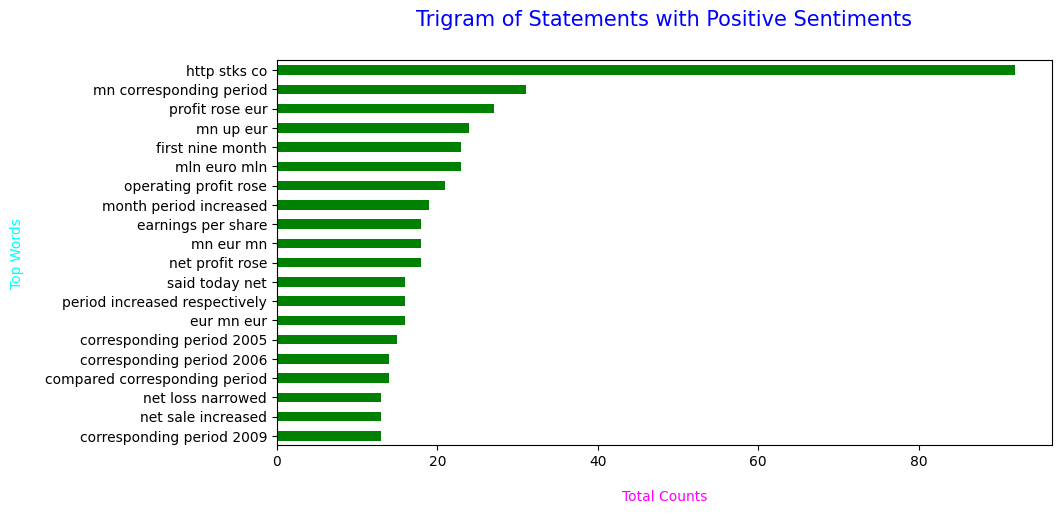

In [ ]:
# Finding Trigram for Positive Sentiments
words = Gram_Analysis(Positive["processed_text"], 3, 20)
Trigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="green")
plt.title("Trigram of Statements with Positive Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

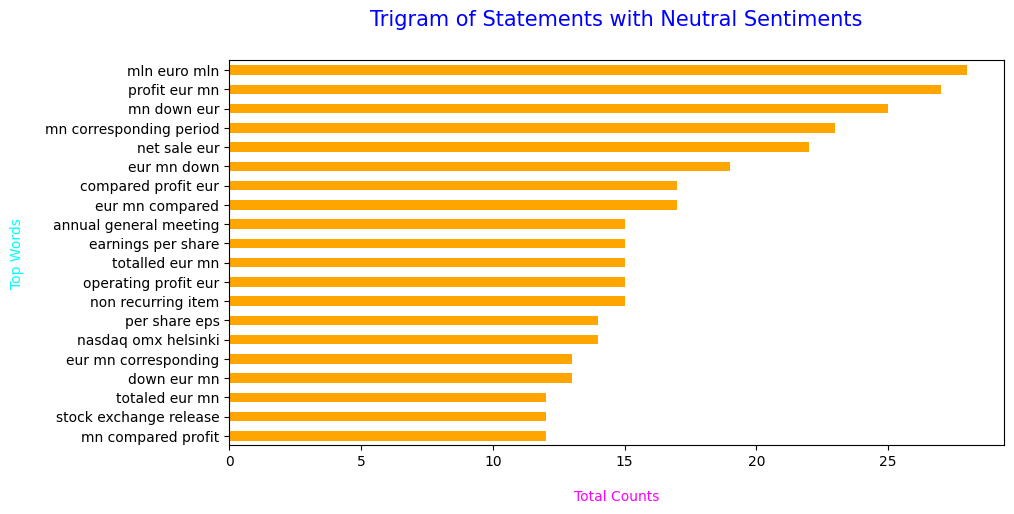

In [ ]:
# Finding Trigram for Neutral Sentiments
words = Gram_Analysis(Neutral["processed_text"], 3, 20)
Trigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="orange")
plt.title("Trigram of Statements with Neutral Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

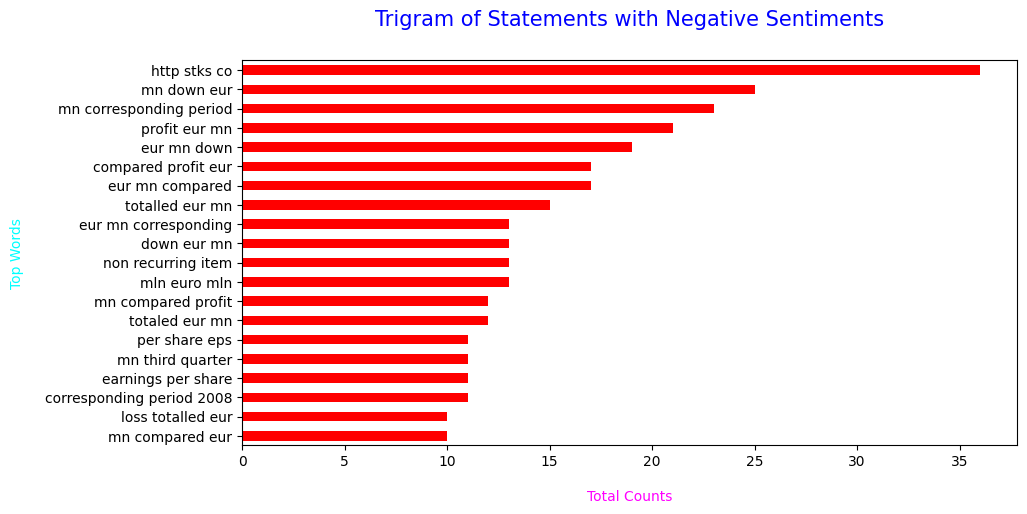

In [ ]:
# Finding Trigram for Negative Sentiments
words = Gram_Analysis(Negative["processed_text"], 3, 20)
Trigram = pd.DataFrame(words, columns=["Words", "Counts"])

# Visualization
plt.figure(figsize=(10, 5))
Trigram.groupby("Words").sum()["Counts"].sort_values().plot(kind="barh", color="red")
plt.title("Trigram of Statements with Negative Sentiments", loc="center", fontsize=15, color="blue", pad=25)
plt.xlabel("Total Counts", color="magenta", fontsize=10, labelpad=15)
plt.xticks(rotation=0)
plt.ylabel("Top Words", color="cyan", fontsize=10, labelpad=15)
plt.show()

# Word Clouds

### Word Cloud of Statements with Positive Sentiments

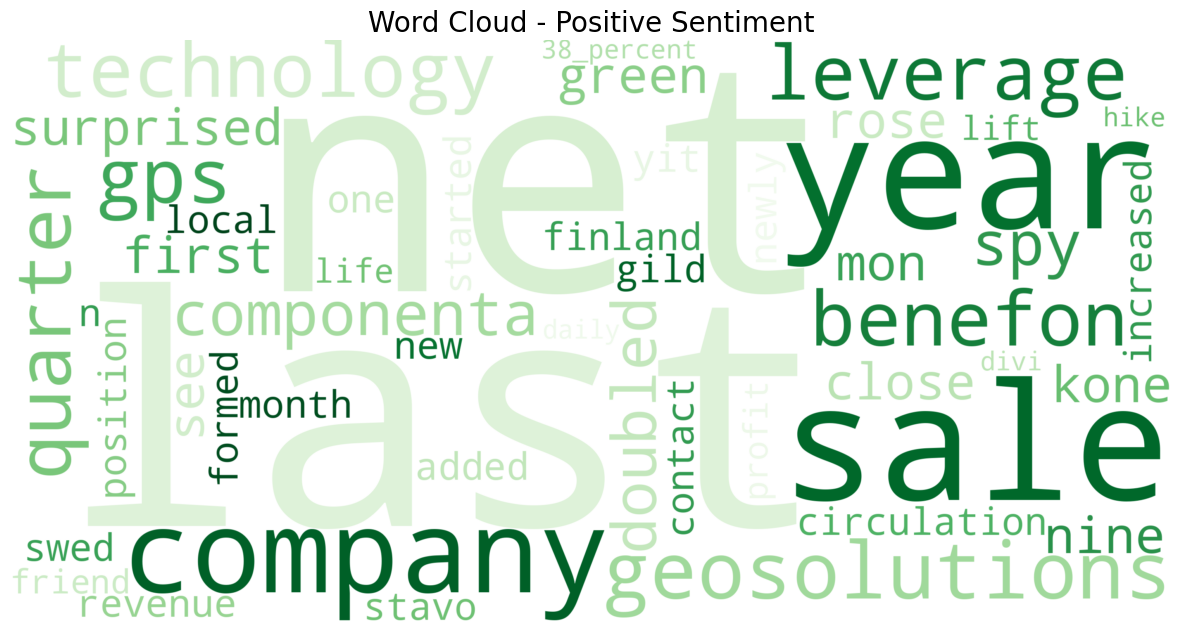

In [ ]:
financial_stopwords = list(set(nltk.corpus.stopwords.words("english")) - set([
      "not", "no", "nor", "up", "down", "above", "below", "high", "low",
      "more", "most", "less", "least", "against", "very", "increase", "decrease"
  ]))
wordCloud = WordCloud(max_words=50, width=3000, height=1500, stopwords=financial_stopwords, background_color='white',colormap='Greens').generate(str(Positive["processed_text"]))
plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Sentiment", fontsize=20)
plt.show()

## Word Cloud of Statements with Neutral Sentiments

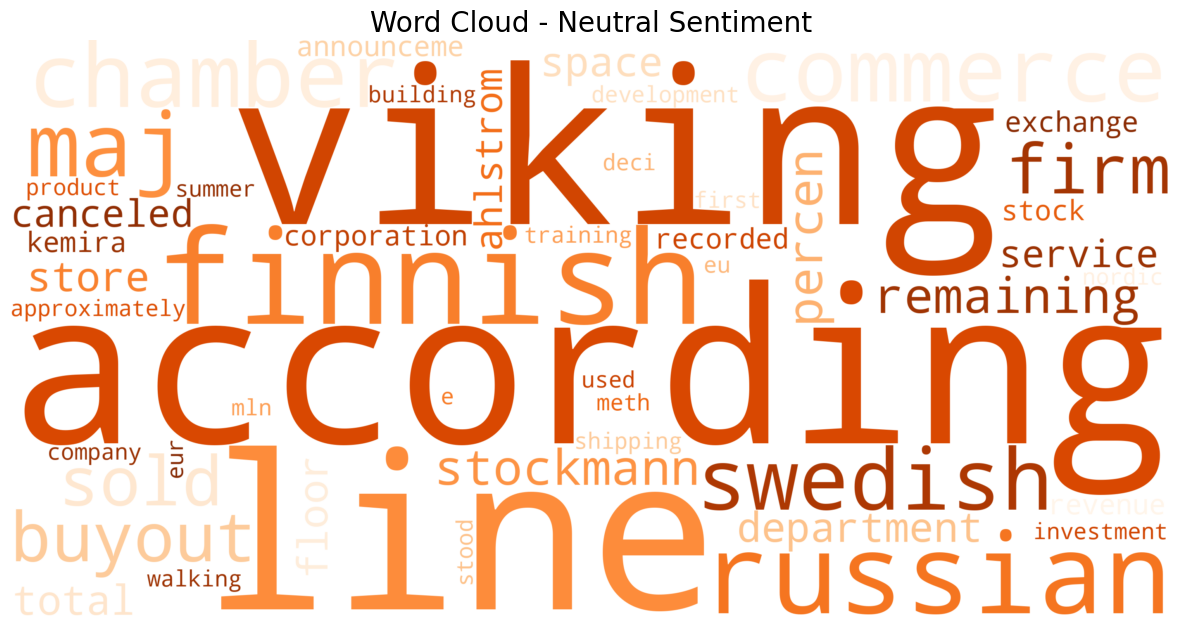

In [ ]:
wordCloud = WordCloud(max_words=50, width=3000, height=1500, stopwords=financial_stopwords, background_color='white',colormap='Oranges').generate(str(Neutral["processed_text"]))
plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Neutral Sentiment", fontsize=20)
plt.show()

## Word Cloud of Statements with Negative Sentiments

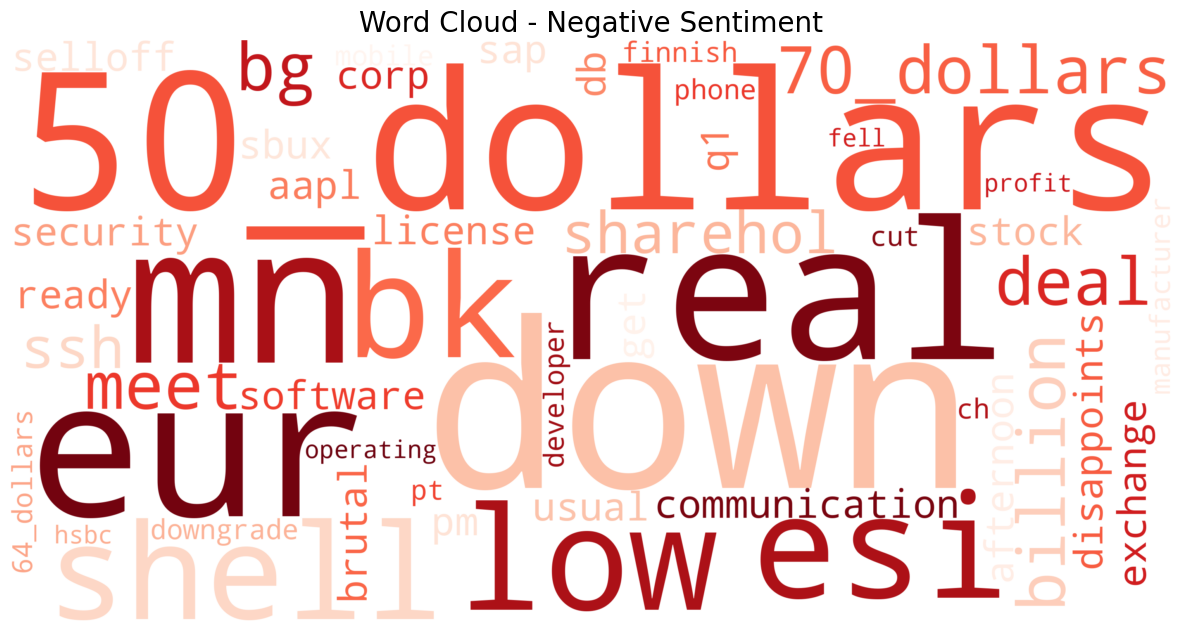

In [ ]:
wordCloud = WordCloud(max_words=50, width=3000, height=1500, stopwords=financial_stopwords, background_color='white',colormap='Reds').generate(str(Negative["processed_text"]))
plt.figure(figsize=(15, 15))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Sentiment", fontsize=20)
plt.show()

# Opinion Mining using spaCy
##Dependency-based Parsing for Sentiment Analysis

This section extracts opinion words by identifying adjective-noun pairs in the text using spaCy's dependency parser.

•⁠  ⁠We focus on adjectives modifying nouns (⁠ amod ⁠) and adjectives linked as nominal subjects (⁠ nsubj ⁠).
•⁠  ⁠These pairs typically represent subjective expressions about entities or aspects.

In [ ]:
import spacy

print("Loading spaCy English model...")
nlp = spacy.load("en_core_web_sm")

def extract_pairs(text):
    doc = nlp(text)
    pairs = []
    for token in doc:
        # Adjective modifier: ADJ ← amod ← NOUN
        if token.dep_ == 'amod' and token.head.pos_ == 'NOUN':
            pairs.append((token.head.text, token.text))
        # Nominal subject: NOUN ← nsubj ← ADJ
        if token.dep_ == 'nsubj' and token.head.pos_ == 'ADJ':
            pairs.append((token.text, token.head.text))
    return pairs

# Sample first 20 non-null sentences
sample = dataset['processed_text'].dropna().astype(str).iloc[:20]

for i, text in enumerate(sample, 1):
    print(f"\nSentence {i}: {text}")
    print("Extracted (Noun, Adjective) Pairs:")
    pairs = extract_pairs(text)
    if pairs:
        for pair in pairs:
            print("    ", pair)
    else:
        print("    No pairs found.")

Loading spaCy English model...

Sentence 1: geosolutions technology leverage benefon gps solution providing location based search technology community platform location relevant multimedia content new powerful commercial model
Extracted (Noun, Adjective) Pairs:
     ('content', 'based')
     ('content', 'relevant')
     ('model', 'new')
     ('model', 'powerful')
     ('model', 'commercial')

Sentence 2: esi low down 1 50_dollars 2 50_dollars bk real possibility
Extracted (Noun, Adjective) Pairs:
     ('possibility', 'real')

Sentence 3: last quarter 2010 componenta net sale doubled eur131m eur76m period year earlier moved zero pre tax profit pre tax loss eur7m
Extracted (Noun, Adjective) Pairs:
     ('quarter', 'last')

Sentence 4: according finnish russian chamber commerce major construction company finland operating russia
Extracted (Noun, Adjective) Pairs:
     ('finland', 'major')

Sentence 5: swedish buyout firm sold remaining 22 4 percent stake almost eighteen month taking compa

In [ ]:
# Choose an example sentence from your sample
example = sample.iloc[8]
doc = nlp(example)

# Render the dependency parse in Jupyter Notebook
displacy.render(doc, style='dep', jupyter=True, options={'compact': True, 'distance': 90})

# Aspect-Based Sentiment Analysis (ABSA)

**Steps involved:**

1. **Aspect Extraction:**  
   Extract relevant aspects from text using rule-based methods such as noun chunks and named entities.

2. **Sentiment Assignment:**  
   Assign sentiment labels (positive, neutral, negative) to each aspect by analyzing the sentences containing those aspects. A simple heuristic approach uses polarity scores from TextBlob.

3. **Output:**  
   Generate a mapping from each aspect to its corresponding sentiment for each text entry.

This approach allows us to get fine-grained sentiment insights on different features mentioned in the reviews or documents.


Output: aspect → sentiment mapping.

In [ ]:
def extract_aspects(text):
    doc = nlp(text)
    aspects = set()

    for chunk in doc.noun_chunks:
        aspects.add(chunk.text.lower())
    for ent in doc.ents:
        aspects.add(ent.text.lower())
    return list(aspects)

def aspect_sentiment_mapping(text):
    aspects = extract_aspects(text)
    aspect_sentiments = {}

    # Split text into sentences for more precise aspect context
    doc = nlp(text)
    sentences = list(doc.sents)

    for aspect in aspects:
        # Collect sentences containing the aspect
        aspect_sents = [sent.text for sent in sentences if aspect in sent.text.lower()]
        if aspect_sents:
            combined_text = " ".join(aspect_sents)
            sentiment_score = TextBlob(combined_text).sentiment.polarity

            # Simple rule: polarity > 0.1 → positive, < -0.1 → negative, else neutral
            if sentiment_score > 0.1:
                sentiment = 'positive'
            elif sentiment_score < -0.1:
                sentiment = 'negative'
            else:
                sentiment = 'neutral'
            aspect_sentiments[aspect] = sentiment
        else:
            aspect_sentiments[aspect] = 'neutral'

    return aspect_sentiments

In [ ]:
# Apply to each text entry
dataset['aspect_sentiments'] = dataset['processed_text'].apply(aspect_sentiment_mapping)

# Show example output for first 3 entries
for i, row in dataset.head(5).iterrows():
    print(f"\nText {i}:\n{row['processed_text']}\nAspect Sentiments:")
    for aspect, sentiment in row['aspect_sentiments'].items():
        print(f"  {aspect}: {sentiment}")


Text 0:
geosolutions technology leverage benefon gps solution providing location based search technology community platform location relevant multimedia content new powerful commercial model
Aspect Sentiments:
  new powerful commercial model: positive
  location based search technology community platform location relevant multimedia content: positive
  solution: positive
  geosolutions technology leverage benefon: positive

Text 1:
esi low down 1 50_dollars 2 50_dollars bk real possibility
Aspect Sentiments:
  1 50_dollars: neutral
  esi: neutral
  real possibility: neutral

Text 2:
last quarter 2010 componenta net sale doubled eur131m eur76m period year earlier moved zero pre tax profit pre tax loss eur7m
Aspect Sentiments:
  tax loss: neutral
  eur131m eur76: neutral
  period year earlier: neutral
  2010 componenta net sale: neutral
  eur76: neutral
  zero: neutral
  zero pre: neutral
  tax profit: neutral
  eur7: neutral
  last quarter 2010: neutral
  eur131: neutral

Text 3:
accor

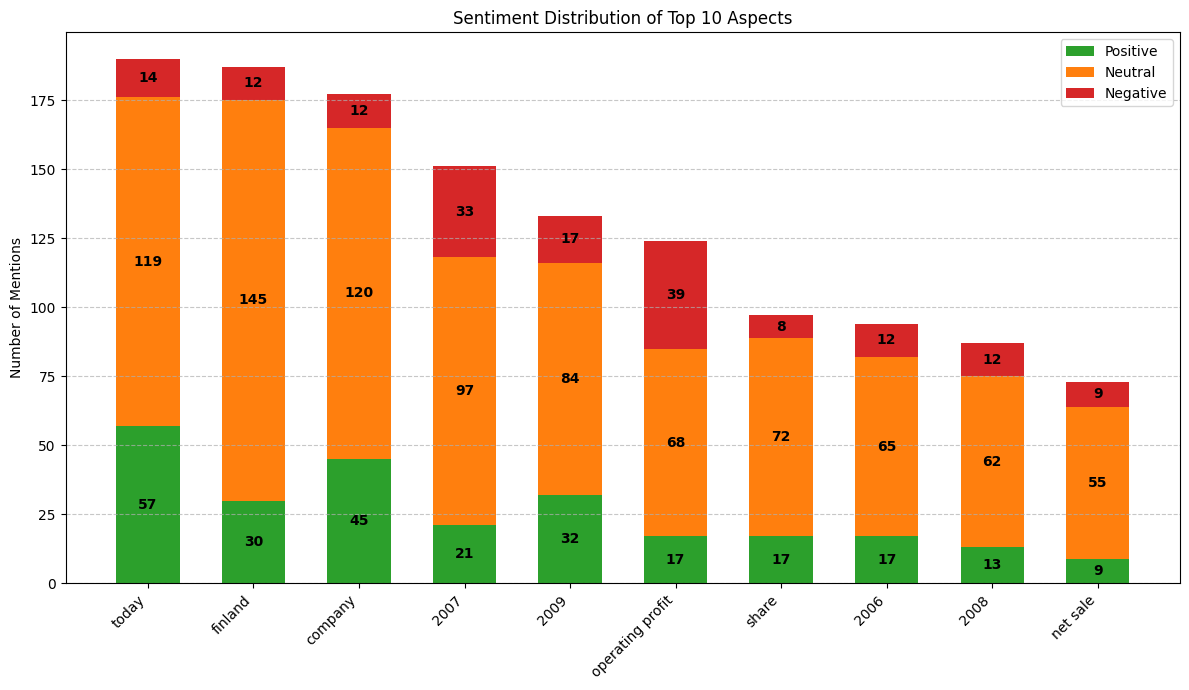

In [ ]:
# Aggregate all aspects and their sentiments across the dataset
all_aspects = []
for d in dataset['aspect_sentiments']:
    all_aspects.extend([(aspect, sentiment) for aspect, sentiment in d.items()])

# Count sentiment occurrences per aspect
sentiment_counter = {}
for aspect, sentiment in all_aspects:
    if aspect not in sentiment_counter:
        sentiment_counter[aspect] = Counter()
    sentiment_counter[aspect][sentiment] += 1

# Select top 10 most mentioned aspects by total count
top_aspects = sorted(sentiment_counter.items(), key=lambda x: sum(x[1].values()), reverse=True)[:10]

# Prepare data for plotting
labels = [aspect for aspect, _ in top_aspects]
positive_counts = [counts.get('positive', 0) for _, counts in top_aspects]
neutral_counts = [counts.get('neutral', 0) for _, counts in top_aspects]
negative_counts = [counts.get('negative', 0) for _, counts in top_aspects]

x = np.arange(len(labels))
width = 0.6

fig, ax = plt.subplots(figsize=(12, 7))

p1 = ax.bar(x, positive_counts, width, label='Positive', color='#2ca02c')  # Green
p2 = ax.bar(x, neutral_counts, width, bottom=positive_counts, label='Neutral', color='#ff7f0e')  # Orange
bottoms = np.array(positive_counts) + np.array(neutral_counts)
p3 = ax.bar(x, negative_counts, width, bottom=bottoms, label='Negative', color='#d62728')  # Red

# Function to add labels on bars
def add_labels(bars, counts, bottoms=None):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if bottoms is not None:
            y = bottoms[i] + height / 2
        else:
            y = height / 2
        if counts[i] > 0:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                y,
                str(counts[i]),
                ha='center',
                va='center',
                fontsize=10,
                color='black',
                fontweight='bold'
            )

# Add numbers to each segment
add_labels(p1, positive_counts)
add_labels(p2, neutral_counts, bottoms=positive_counts)
add_labels(p3, negative_counts, bottoms=bottoms)

ax.set_ylabel('Number of Mentions')
ax.set_title('Sentiment Distribution of Top 10 Aspects')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Feature Engineering

## Encoding Our Target Variable

We have encoded our sentiment labels into numeric values for model training. This step is necessary as machine learning algorithms work with numeric data.

In [ ]:
# Create a copy of the dataset for modeling
model_data = dataset.copy()

# Encode sentiment labels
Encoder = LabelEncoder()
model_data["sentiment_encoded"] = Encoder.fit_transform(model_data["Sentiment"])

# Check the mapping
print("Sentiment encoding mapping:")
for i, sentiment in enumerate(Encoder.classes_):
    print(f"{sentiment} -> {i}")

# Check distribution of encoded sentiments
model_data["sentiment_encoded"].value_counts()

Sentiment encoding mapping:
negative -> 0
neutral -> 1
positive -> 2


,count
sentiment_encoded,
1,3130
2,1852
0,860


## TF-IDF Vectorization
We have used TF-IDF vectorization to convert our text data into numerical features that can be used by machine learning algorithms. This technique weighs the importance of words based on their frequency in documents and across the corpus.

In [ ]:
# Defining our vectorizer with 5000 features and with bigram model
TF_IDF = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# Fitting and transforming our processed text into a matrix of weighted words
# This will be our independent features
X = TF_IDF.fit_transform(model_data["processed_text"])

# Check our matrix shape
print(f"TF-IDF matrix shape: {X.shape}")

# Declaring our target variable
y = model_data["sentiment_encoded"]

TF-IDF matrix shape: (5842, 5000)


## Resampling Our Dataset
We've used **SMOTE (Synthetic Minority Oversampling Technique)** to address the class imbalance in our dataset. This technique generates synthetic samples for the minority classes to create a balanced dataset for training.

In [ ]:
# Check class distribution before resampling
print("Class distribution before resampling:")
print(Counter(y))

# Apply SMOTE to balance the dataset
Balancer = SMOTE(random_state=42)
X_balanced, y_balanced = Balancer.fit_resample(X, y)

# Check class distribution after resampling
print("\nClass distribution after resampling:")
print(Counter(y_balanced))

Class distribution before resampling:
Counter({1: 3130, 2: 1852, 0: 860})

Class distribution after resampling:
Counter({2: 3130, 0: 3130, 1: 3130})


<ipython-input-89-2888197638>:38: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


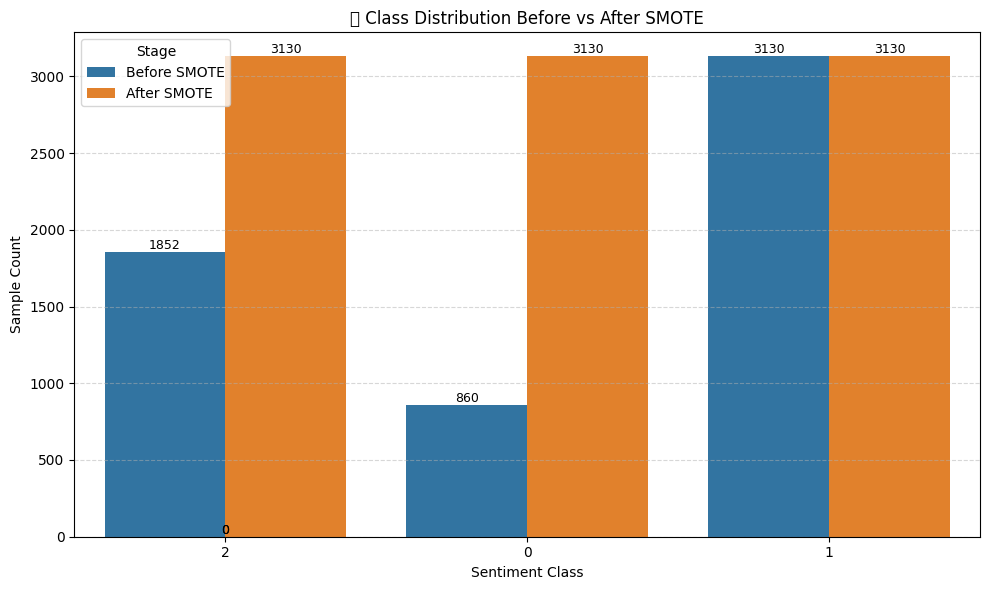

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd

# Count class distribution
before_counts = Counter(y)
after_counts = Counter(y_balanced)

# Convert to DataFrames
df_before = pd.DataFrame.from_dict(before_counts, orient='index').reset_index()
df_before.columns = ['Class', 'Count']
df_before['Stage'] = 'Before SMOTE'

df_after = pd.DataFrame.from_dict(after_counts, orient='index').reset_index()
df_after.columns = ['Class', 'Count']
df_after['Stage'] = 'After SMOTE'

# Combine for plotting
df_combined = pd.concat([df_before, df_after], axis=0)
df_combined['Class'] = df_combined['Class'].astype(str)  # Optional: show labels as strings

# Plot with labels
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df_combined, x='Class', y='Count', hue='Stage')
plt.title("📊 Class Distribution Before vs After SMOTE")
plt.xlabel("Sentiment Class")
plt.ylabel("Sample Count")
plt.grid(True, axis='y', linestyle='--', alpha=0.5)

# Add labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=9, color='black')

plt.tight_layout()
plt.show()


## Splitting Our Dataset
We've split our balanced dataset into training (75%) and testing (25%) sets. This allows us to train our models on one portion of the data and evaluate their performance on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.25, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (7042, 5000)
Testing set shape: (2348, 5000)


# Model Selection and Evaluation - Traditional ML Mode
- we used Decision Tree, Logistic Reggressoin, SVC, Random Forest Classifier, Naive Bayes and KNN to train
- 10 fold cross validation

In [ ]:
# Define models to evaluate
DTree = DecisionTreeClassifier(random_state=42)
LogReg = LogisticRegression(random_state=42, max_iter=1000)
SVMModel = SVC(random_state=42)
RForest = RandomForestClassifier(random_state=42)
Bayes = BernoulliNB()
KNN = KNeighborsClassifier()

Models = [DTree, LogReg, SVMModel, RForest, Bayes, KNN]
Models_Dict = {0: "Decision Tree", 1: "Logistic Regression", 2: "SVC", 3: "Random Forest", 4: "Naive Bayes", 5: "K-Neighbors"}

# Perform cross-validation for each model
print("Model performance using 10-fold cross-validation:")
for i, model in enumerate(Models):
  cv_score = cross_val_score(model, X_train, y_train, cv=10, scoring="accuracy").mean()
  print(f"{Models_Dict[i]} Test Accuracy: {cv_score:.4f}")

Model performance using 10-fold cross-validation:
Decision Tree Test Accuracy: 0.7292
Logistic Regression Test Accuracy: 0.8070
SVC Test Accuracy: 0.8195
Random Forest Test Accuracy: 0.7934
Naive Bayes Test Accuracy: 0.7611
K-Neighbors Test Accuracy: 0.6515


## Randomized Search tested random combinations of hyperparameters (up to 10, or fewer if total possible combos < 10).


In [ ]:
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd

# Define parameter distributions for each model
param_dists = {
    "Decision Tree": {"max_depth": [None, 10, 20, 30], "min_samples_split": [2, 5, 10]},
    "Logistic Regression": {"C": np.logspace(-4, 4, 10), "penalty": ['l1', 'l2'], "solver": ['liblinear']},
    "SVC": {"C": [0.1, 1, 10], "kernel": ['linear', 'rbf']},
    "Random Forest": {"n_estimators": [50, 100], "max_depth": [None, 10, 20]},
    "Naive Bayes": {"alpha": [0.1, 0.5, 1.0]},
    "K-Neighbors": {"n_neighbors": [3, 5, 7], "weights": ['uniform', 'distance']}
}

# Model dictionary
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "SVC": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": BernoulliNB(),
    "K-Neighbors": KNeighborsClassifier()
}

# Dictionaries to store best params and accuracy
best_params = {}
best_scores = {}

# Perform Randomized Search
for name, model in models.items():
    print(f"\n🔍 Randomized Search for {name}")

    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dists[name],
        n_iter=10,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=0,
        random_state=42
    )

    search.fit(X_train, y_train)
    best_params[name] = search.best_params_
    best_scores[name] = search.best_score_ * 100

# Display summary table
summary_df = pd.DataFrame({
    "Model": list(best_params.keys()),
    "Best Accuracy (%)": [f"{best_scores[m]:.2f}" for m in best_params],
    "Best Parameters": [str(best_params[m]) for m in best_params]
})

from IPython.display import display, Markdown

# Print markdown-formatted table
markdown_table = "## 🔎 Randomized Search Summary\n\n"
markdown_table += "| Model | Best Accuracy (%) | Best Parameters |\n"
markdown_table += "|-------|--------------------|------------------|\n"
for i in summary_df.index:
    markdown_table += f"| {summary_df['Model'][i]} | {summary_df['Best Accuracy (%)'][i]} | `{summary_df['Best Parameters'][i]}` |\n"

display(Markdown(markdown_table))



🔍 Randomized Search for Decision Tree

🔍 Randomized Search for Logistic Regression

🔍 Randomized Search for SVC


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



🔍 Randomized Search for Random Forest


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



🔍 Randomized Search for Naive Bayes

🔍 Randomized Search for K-Neighbors


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


## 🔎 Randomized Search Summary

| Model | Best Accuracy (%) | Best Parameters |
|-------|--------------------|------------------|
| Decision Tree | 71.51 | `{'min_samples_split': 5, 'max_depth': None}` |
| Logistic Regression | 79.82 | `{'solver': 'liblinear', 'penalty': 'l2', 'C': np.float64(2.782559402207126)}` |
| SVC | 82.16 | `{'kernel': 'rbf', 'C': 10}` |
| Random Forest | 78.43 | `{'n_estimators': 100, 'max_depth': None}` |
| Naive Bayes | 77.83 | `{'alpha': 0.1}` |
| K-Neighbors | 68.63 | `{'weights': 'distance', 'n_neighbors': 3}` |


## Best Model Training and Prediction
Now we train all the models with the best parameters

Decision Tree Test Accuracy: 71.98%
Logistic Regression Test Accuracy: 82.41%
SVC Test Accuracy: 82.37%
Random Forest Test Accuracy: 79.98%
Naive Bayes Test Accuracy: 77.98%
K-Neighbors Test Accuracy: 73.81%


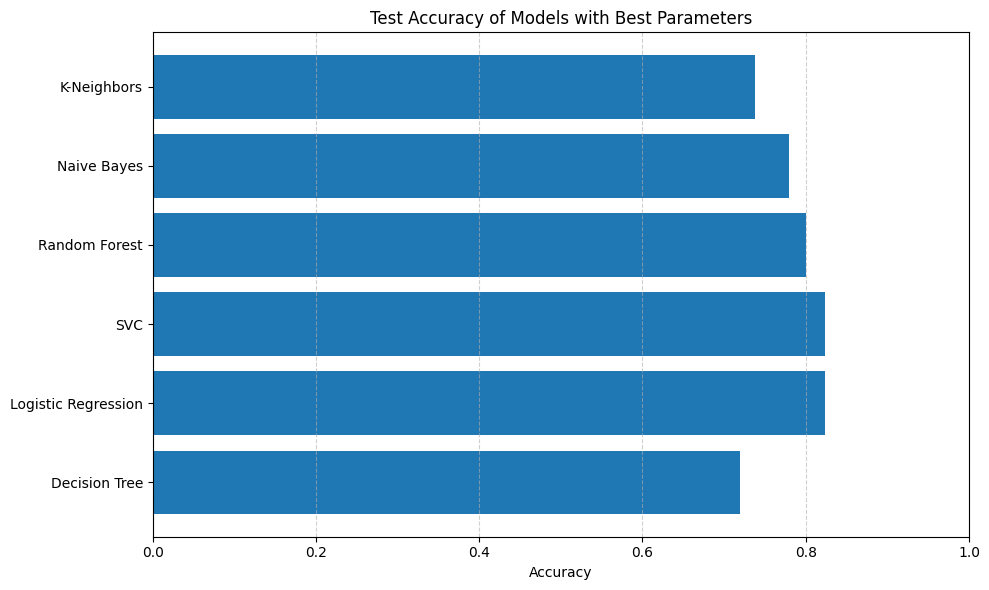

In [ ]:
# Model class mappings
model_classes = {
    "Decision Tree": DecisionTreeClassifier,
    "Logistic Regression": LogisticRegression,
    "SVC": SVC,
    "Random Forest": RandomForestClassifier,
    "Naive Bayes": BernoulliNB,
    "K-Neighbors": KNeighborsClassifier
}

# Train and evaluate each model
results = {}

for name, params in best_params.items():
    if name in ["Naive Bayes", "K-Neighbors"]:
        model = model_classes[name](**params)
    else:
        model = model_classes[name](**params, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"{name} Test Accuracy: {accuracy * 100:.2f}%")

# Plotting the results
model_names = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
plt.barh(model_names, accuracies)
plt.xlabel("Accuracy")
plt.title("Test Accuracy of Models with Best Parameters")
plt.xlim(0, 1)
plt.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


## Model Evaluation – Accuracy, Precision, Recall, F1


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate all models on test set
metrics = []

for name, params in best_params.items():
    if name in ["Naive Bayes", "K-Neighbors"]:
        model = model_classes[name](**params)
    else:
        model = model_classes[name](**params, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    metrics.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "Recall": recall_score(y_test, y_pred, average='weighted'),
        "F1 Score": f1_score(y_test, y_pred, average='weighted')
    })

# Display evaluation metrics in a DataFrame
metrics_df = pd.DataFrame(metrics).sort_values(by="F1 Score", ascending=False)
display(metrics_df)


,Model,Accuracy,Precision,Recall,F1 Score
2,SVC,0.823680,0.828216,0.823680,0.825260
1,Logistic Regression,0.824106,0.824671,0.824106,0.821472
3,Random Forest,0.799830,0.804341,0.799830,0.801334
4,Naive Bayes,0.779813,0.781516,0.779813,0.780250
5,K-Neighbors,0.738075,0.739796,0.738075,0.734010
0,Decision Tree,0.719761,0.717409,0.719761,0.717850


## Plot Confusion Matrices

We've evaluated our model using several metrics, including accuracy, confusion matrix, and a detailed classification report. These metrics provide insights into our model's performance on different sentiment categories.


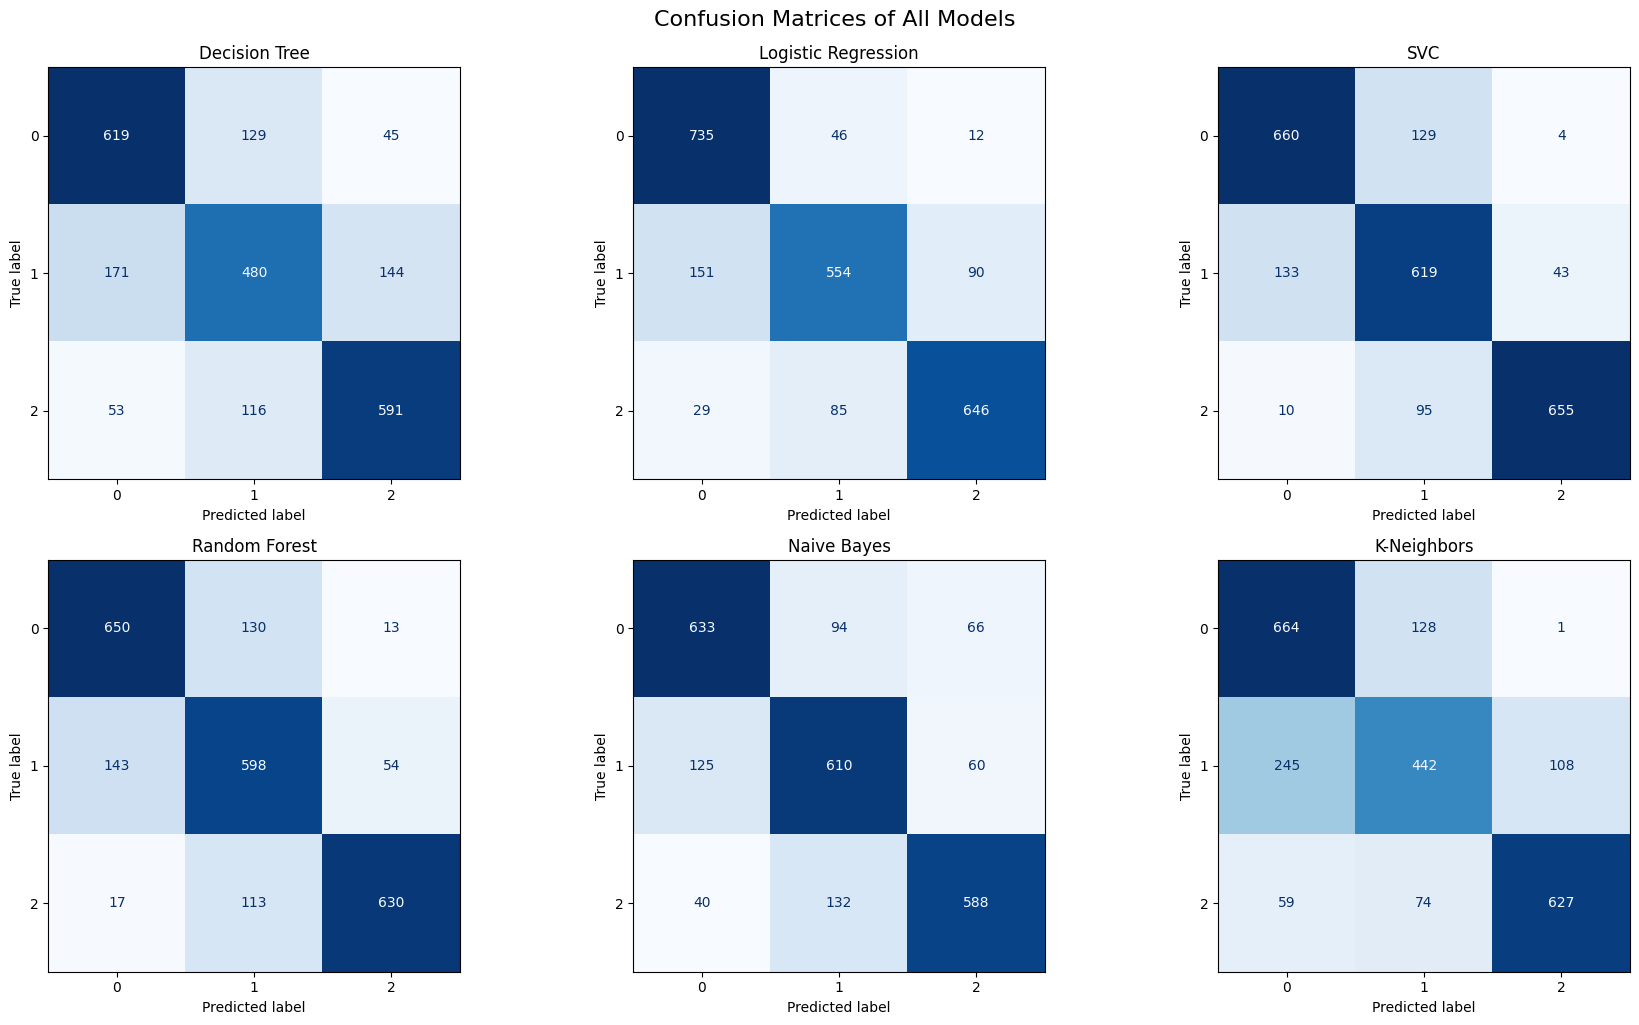

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns

# Set up multiple subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, (name, params) in enumerate(best_params.items()):
    if name in ["Naive Bayes", "K-Neighbors"]:
        model = model_classes[name](**params)
    else:
        model = model_classes[name](**params, random_state=42)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred, ax=axes[idx], cmap='Blues', colorbar=False
    )
    axes[idx].set_title(name)

plt.tight_layout()
plt.suptitle("Confusion Matrices of All Models", fontsize=16, y=1.02)
plt.show()


## Fine-tune a Transformer (BERT)

In [ ]:
from sklearn.model_selection import train_test_split

# Extract text and labels
texts = model_data["processed_text"].tolist()
labels = model_data["sentiment_encoded"].tolist()

# Train-test split (stratified)
X_text_train, X_text_test, y_train_encoded, y_test_encoded = train_test_split(
    texts, labels, test_size=0.25, stratify=labels, random_state=42
)

print(f"Train size: {len(X_text_train)}, Test size: {len(X_text_test)}")


Train size: 4381, Test size: 1461


## Tokenization


In [ ]:
from transformers import BertTokenizerFast

tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(X_text_train, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_text_test, truncation=True, padding=True, max_length=512)

# Sanity check
print(len(train_encodings["input_ids"]), len(y_train_encoded))
print(len(test_encodings["input_ids"]), len(y_test_encoded))


4381 4381
1461 1461


## Create Custom Dataset

In [ ]:
import torch

class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

# Create datasets
train_dataset = SentimentDataset(train_encodings, y_train_encoded)
test_dataset = SentimentDataset(test_encodings, y_test_encoded)


## Load Model and Set Training Arguments

In [ ]:
from transformers import BertForSequenceClassification, TrainingArguments

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=len(set(y_train_encoded))
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    logging_dir='./logs',
    logging_steps=10
    # Do NOT include: evaluation_strategy, save_strategy, load_best_model_at_end, etc.
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()


Step,Training Loss
10,1.069700
20,0.955400
30,0.919500
40,0.947000
50,0.828200
60,0.797300
70,0.710400
80,0.711000
90,0.710300
100,0.614300


TrainOutput(global_step=822, training_loss=0.43346974695976054, metrics={'train_runtime': 250.8489, 'train_samples_per_second': 52.394, 'train_steps_per_second': 3.277, 'total_flos': 452524758781914.0, 'train_loss': 0.43346974695976054, 'epoch': 3.0})

## Evaluate and Visualize

✅ Accuracy: 75.77%
✅ F1 Score (weighted): 0.7643

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.57      0.50       215
           1       0.84      0.77      0.80       783
           2       0.82      0.82      0.82       463

    accuracy                           0.76      1461
   macro avg       0.70      0.72      0.71      1461
weighted avg       0.77      0.76      0.76      1461



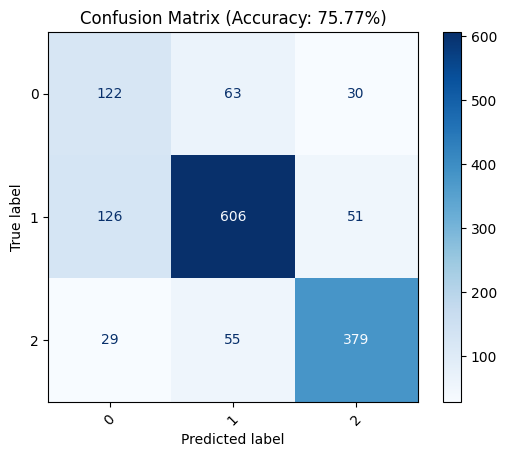

<Figure size 1000x600 with 0 Axes>

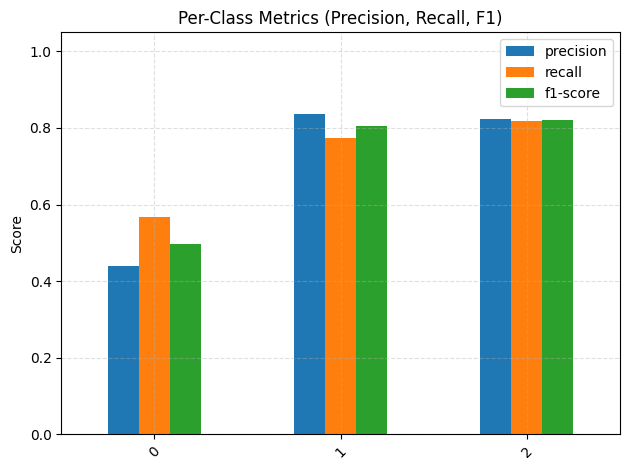

In [ ]:
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, f1_score, precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get predictions
preds_output = trainer.predict(test_dataset)
y_pred = preds_output.predictions.argmax(-1)
y_true = y_test_encoded

# Basic metrics
acc = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"✅ Accuracy: {acc * 100:.2f}%")
print(f"✅ F1 Score (weighted): {f1:.4f}")

# Classification Report
report = classification_report(
    y_true, y_pred,
    target_names=[str(c) for c in label_encoder.classes_],
    output_dict=True
)
print("\n📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=[str(c) for c in label_encoder.classes_]))



# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title(f"Confusion Matrix (Accuracy: {acc * 100:.2f}%)")
plt.show()

# Convert report to DataFrame for plotting
report_df = pd.DataFrame(report).transpose().iloc[:-3][['precision', 'recall', 'f1-score']]

# Barplot
plt.figure(figsize=(10, 6))
report_df.plot(kind='bar')
plt.title("Per-Class Metrics (Precision, Recall, F1)")
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


#Conclusion
### Model Performance Comparison, Insights & Future Works

We compared the performance of a fine-tuned BERT model against several traditional ML classifiers on the same financial sentiment dataset.

---

#### **BERT (Transformer-based)**
- **Accuracy**: 75.77%
- **Weighted F1 Score**: 0.7643
- **Strengths**:
  - Strong performance on neutral and positive classes (F1: 0.80, 0.82)
  - Better generalization for longer, nuanced text
- **Weaknesses**:
  - Lower performance on minority class 0 (negative), F1 = 0.50

---

#### **Traditional Machine Learning Models (Best Results)**
- **Logistic Regression**: 82.41%
- **SVC**: 82.37%
- **Random Forest**: 79.98%
- **Naive Bayes**: 77.98%
- **KNN**: 73.81%
- **Decision Tree**: 71.98%

---

### **Insights**
- Surprisingly, **Logistic Regression and SVC outperformed BERT** in terms of raw accuracy.
- **Traditional ML models likely benefited from TF-IDF features**, which work well on structured and preprocessed financial text.
- **BERT is better suited for subtle contextual relationships**, but may require more training epochs or larger datasets to outperform simpler models here.
- Class 0 imbalance remains a challenge across all models.

---

### **Conclusion**
- This study compared traditional machine learning models with a transformer-based deep learning model (BERT) for classifying sentiment in financial news headlines. Using preprocessing steps like normalization, TF-IDF, and SMOTE, we built robust pipelines for both approaches.

- **Opinion mining** and **ABSA** further enhanced interpretability by identifying sentiment-laden phrases and aspects. Overall, traditional models remain strong for structured financial text, while BERT shows promise in handling deeper linguistic nuance.


### **Future Works**
- Fine-tune BERT further with **more epochs**, better **learning rates**, and **domain-adaptive pretraining**.
- Explore **ensemble methods** combining classical and transformer models.
- Apply **data augmentation** to better represent minority sentiment classes.
- Integrate **multimodal data** (e.g., stock prices, user behavior) for richer context.
- Deploy the best-performing model as a **real-time financial sentiment tool** for analysts or traders.